In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

In [10]:
df_banca = pd.read_csv('credit_npo.csv')

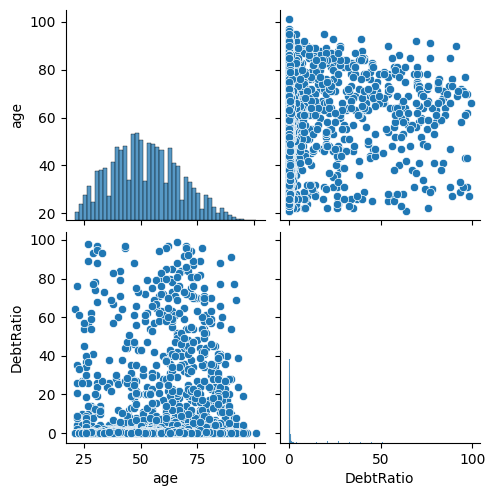

In [ ]:
sns.pairplot(df[['age', 'SeriousDlqin2yrs', 'DebtRatio']],)

In [11]:
df_titanic = pd.read_csv('titanic.csv')

In [ ]:
pd.to_numeric(df_titanic['pclass'], errors= 'coerce')

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: pclass, Length: 891, dtype: int64

In [ ]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [12]:
df_banca['SeriousDlqin2yrs'] = df_banca['SeriousDlqin2yrs'].apply(lambda x: 'debt' if x == 1 else 'no_debt')
df_titanic['survived'] = df_titanic['survived'].apply(lambda x: 'sobrevive' if x == 1 else 'muere')

In [15]:
# version sin generador de lineas

def plot_features_num_classification(df:pd.DataFrame, target_col:str= '', columns:list= [], pvalue:float= 0.05) -> list:

    '''
    Parametros:
    .- df: un dataframe de pandas
    .- target_col: el nombre de la variable target (debe ser categorica objeto/str, si contiene numeros, procede mapearla)
    .- columns: el nombre de las variables numericas del df, adjuntas en una lista (vacia por defecto)
    .- pvalue: el valor con que queremos comprobar la significancia estadistica, 0.05 por defecto

    Esta funcion cumple tras objetivos: a saber:

    1.- retorna una lista con los nombres de las features numericas que superan un test anova de significancia estadistica superior al establecido en pvalue
    2.- printa una relacion de graficas comparativas de correlacion target-variables numericas para su estudio y miniEDA
    3.- printa una relacion de graficas comparativas de colinealidad entre las distinta variables numericas para su estudio y miniEDA

    Explicamos la funcion mas en detalle a continuacion.
    '''

    paramns_ok = paramns_check(df, target_col, columns, pvalue) # comprobamos que los parametros son adecuados, si no lo son retornamos None y printamos que no lo son
    if not paramns_ok:
        print('Los parametros introduciodos son incorrectos.')
        return None

    if not columns: # si no adjuntamos lista de var numericas, cogemos todas las numericas del df
        columns = df.describe().columns.tolist()

    col_anova = [] # creamos lista vacia donde almacenaremos los nombres de var numericas que cumplen el test anova

    # a continuacion realizamos el test anova
    grps = df[target_col].unique().tolist() # almacenamo los diferentes valores posibles del target en una lista
    for feature in columns: # iteramos las var numricas
        prov_list = [] # lista provisional donde almacenaremos las series de realcion de cada var numrica con los diferentes valores del target
        
        for grp in grps:
            prov_list.append(df[df[target_col] == grp][feature]) # agregamos a la lista las series que comentabamos antes
        
        f_st, p_va = stats.f_oneway(*prov_list) # realizamos el test anova sobre la var numerica de turno (en iteracion actual) en relacion con cada valor del target y comprobamos su pvalue en funcion de su varianza
        if p_va <= pvalue: # si hay significancia estadistica recahazamos H0(medias similares) y adjuntamos el nombre de la feature a col_anova 
            col_anova.append(feature) 
    
    # empezamos con las graficas
    col_anova.insert(0, target_col) # adjuntamos el target a col_anova porque lo necesitaremos para comparar y graficar

    # creamos una primera serie de graficas relacion target(categorica) con las features numericas
    # utilizaremos subplots para reflejar cada grafica individualmente. Estos subplots son referenciados mediante arrays, importante

    q_lineas = math.ceil((len(col_anova)-1)/5) # calculamos la cantidad de lineas que compondra en la figura grafica / array (cada linea comprendera 5 subplots / columnas)

    # vamos a jugar con generadores, uno simple en realidad, no lo hemos visto en temario pero para este caso resulta de mucha utilidad
    # para movernos por los subplots de la figura grafica de turno deberemos iterar las columnas segun grafiquemos diferentes relaciones target-features
    # esta iteracion sera tal que asi: 1º columna 0, 2º columna 1, 3º columna 2, 4º columna 3, 5º columna 4, 6º columna 0, 7º columna 1 etc etc
    # necesitamos reseterar la columna cada vez que graficamos una columna 4 (5º grafica seguida) 
    def gen_indice():
        
        while True:
            for linea in range(100):
                for columna in range(5):
                    yield linea, columna

    contador_indice = gen_indice() # instanciamos el generador


    fig, axs = plt.subplots(q_lineas, 5, figsize=(20, 4*q_lineas)) # generamos la figura grafica con la cantidad de lineas y 5 columnas, tamño acorde a la q de lineas
    fig.suptitle('Correlación target categorico VS features numéricas con significancia estadistica > 1-pvalue')
    plt.subplots_adjust(top=0.9)

    linea = 0 # comenzamos en la linea 0, primera
    indice = next(contador_indice)
    # comenzamos a iterar las features que tenemos que graficas
    for feature_index in range(1, len(col_anova)): # rango 1 hata final porque la primera es el target y no queremos graficar target-target
    
        try: # presumimos que la grafica dispondra de mas de 1 linea y graficaremos en consecuencia... 
            for i in df[col_anova[0]].unique():     
                sns.histplot(df[df[col_anova[0]] == i][col_anova[feature_index]], kde= True, ax= axs[indice], label= i)
            axs[indice].legend()
            indice = next(contador_indice)
        except IndexError: # si la figura solo dispone de 1 linea la graficacion dara error y graficamos en consecuencia
            for i in df[col_anova[0]].unique():     
                sns.histplot(df[df[col_anova[0]] == i][col_anova[feature_index]], kde= True, ax= axs[linea], label= i)
            axs[linea].legend()
            linea += 1
    plt.show() # mostramos la figura grafica

    # graficamos la colinealidad
    sns.pairplot(df[col_anova], hue= target_col) # pairplot para todas las features numericas que han superado la significancia estadistica
    plt.suptitle('Colinealidad features numéricas con significancia estadistica > 1-pvalue')
    plt.subplots_adjust(top=0.9) 
    plt.show() # mostramos grafica
    col_anova.remove(target_col) # quitamos el target de la lista de features que han superado el test (ya ha sido util para graficar)
    
    return col_anova # devolvemos los nombres de las features que han superado la significancia estadistica
    

In [17]:
df_ejemplo = pd.read_csv('BankChurners.csv')

In [18]:
df_ejemplo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [19]:
df_ejemplo.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

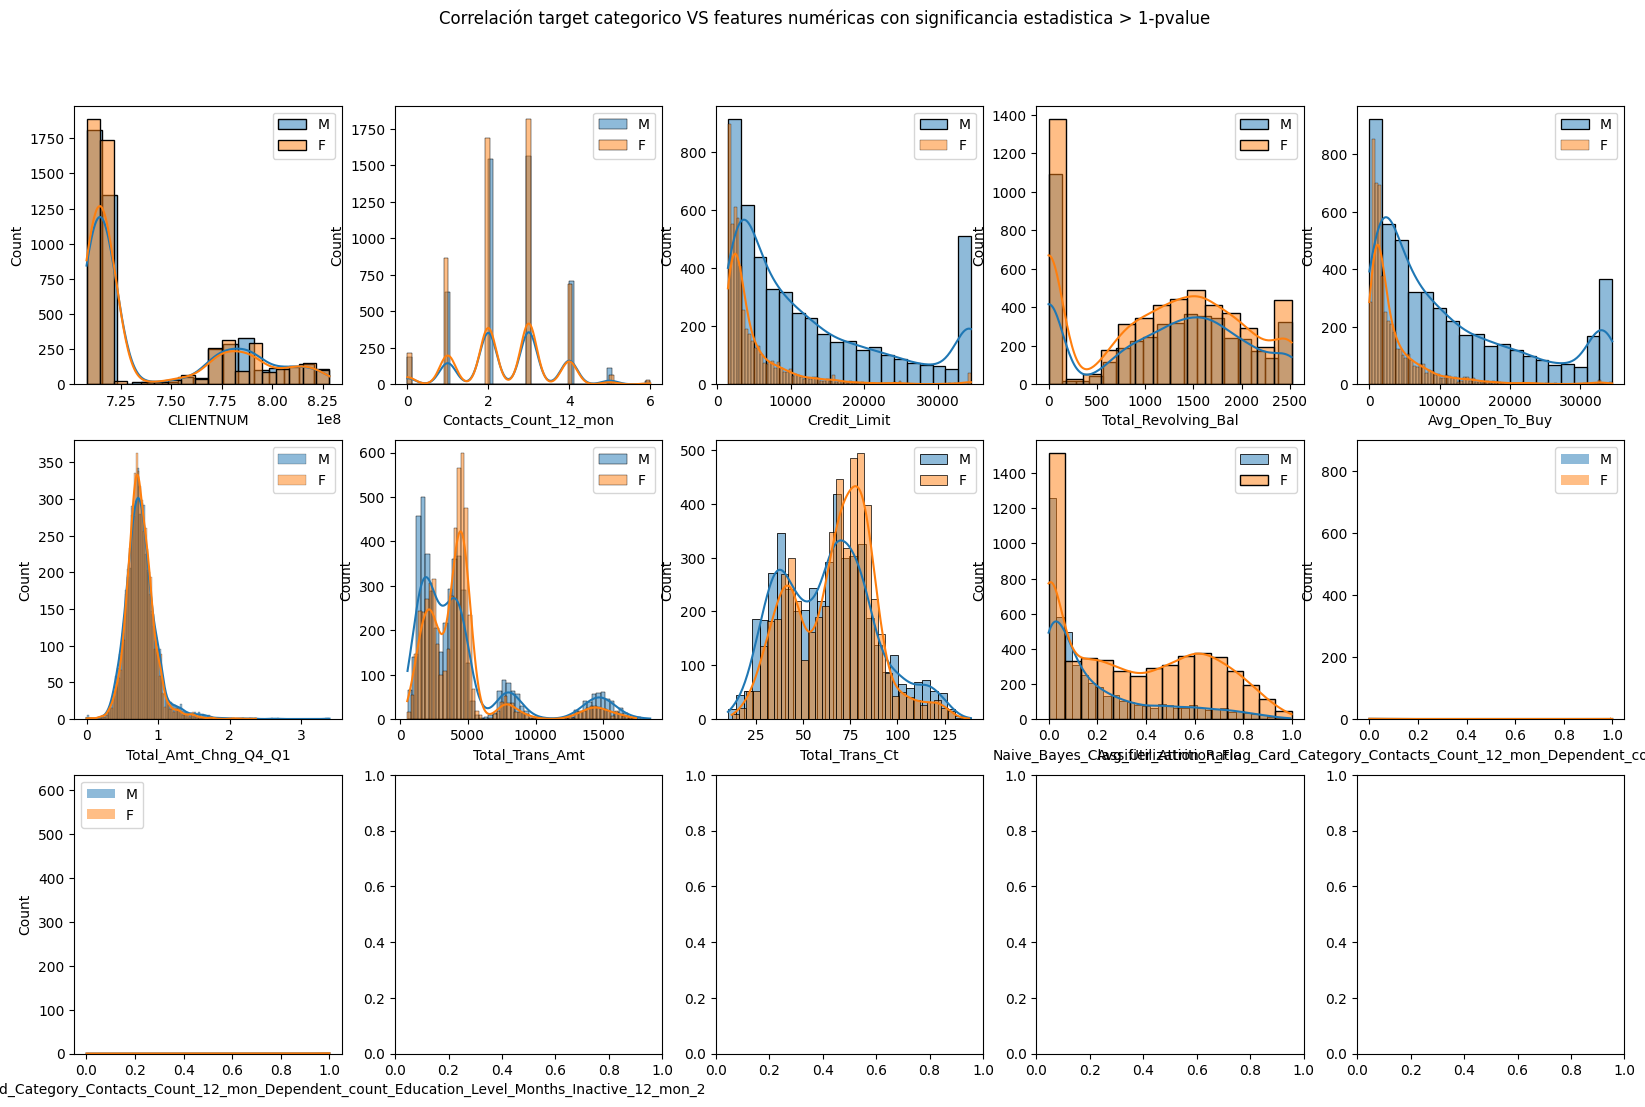

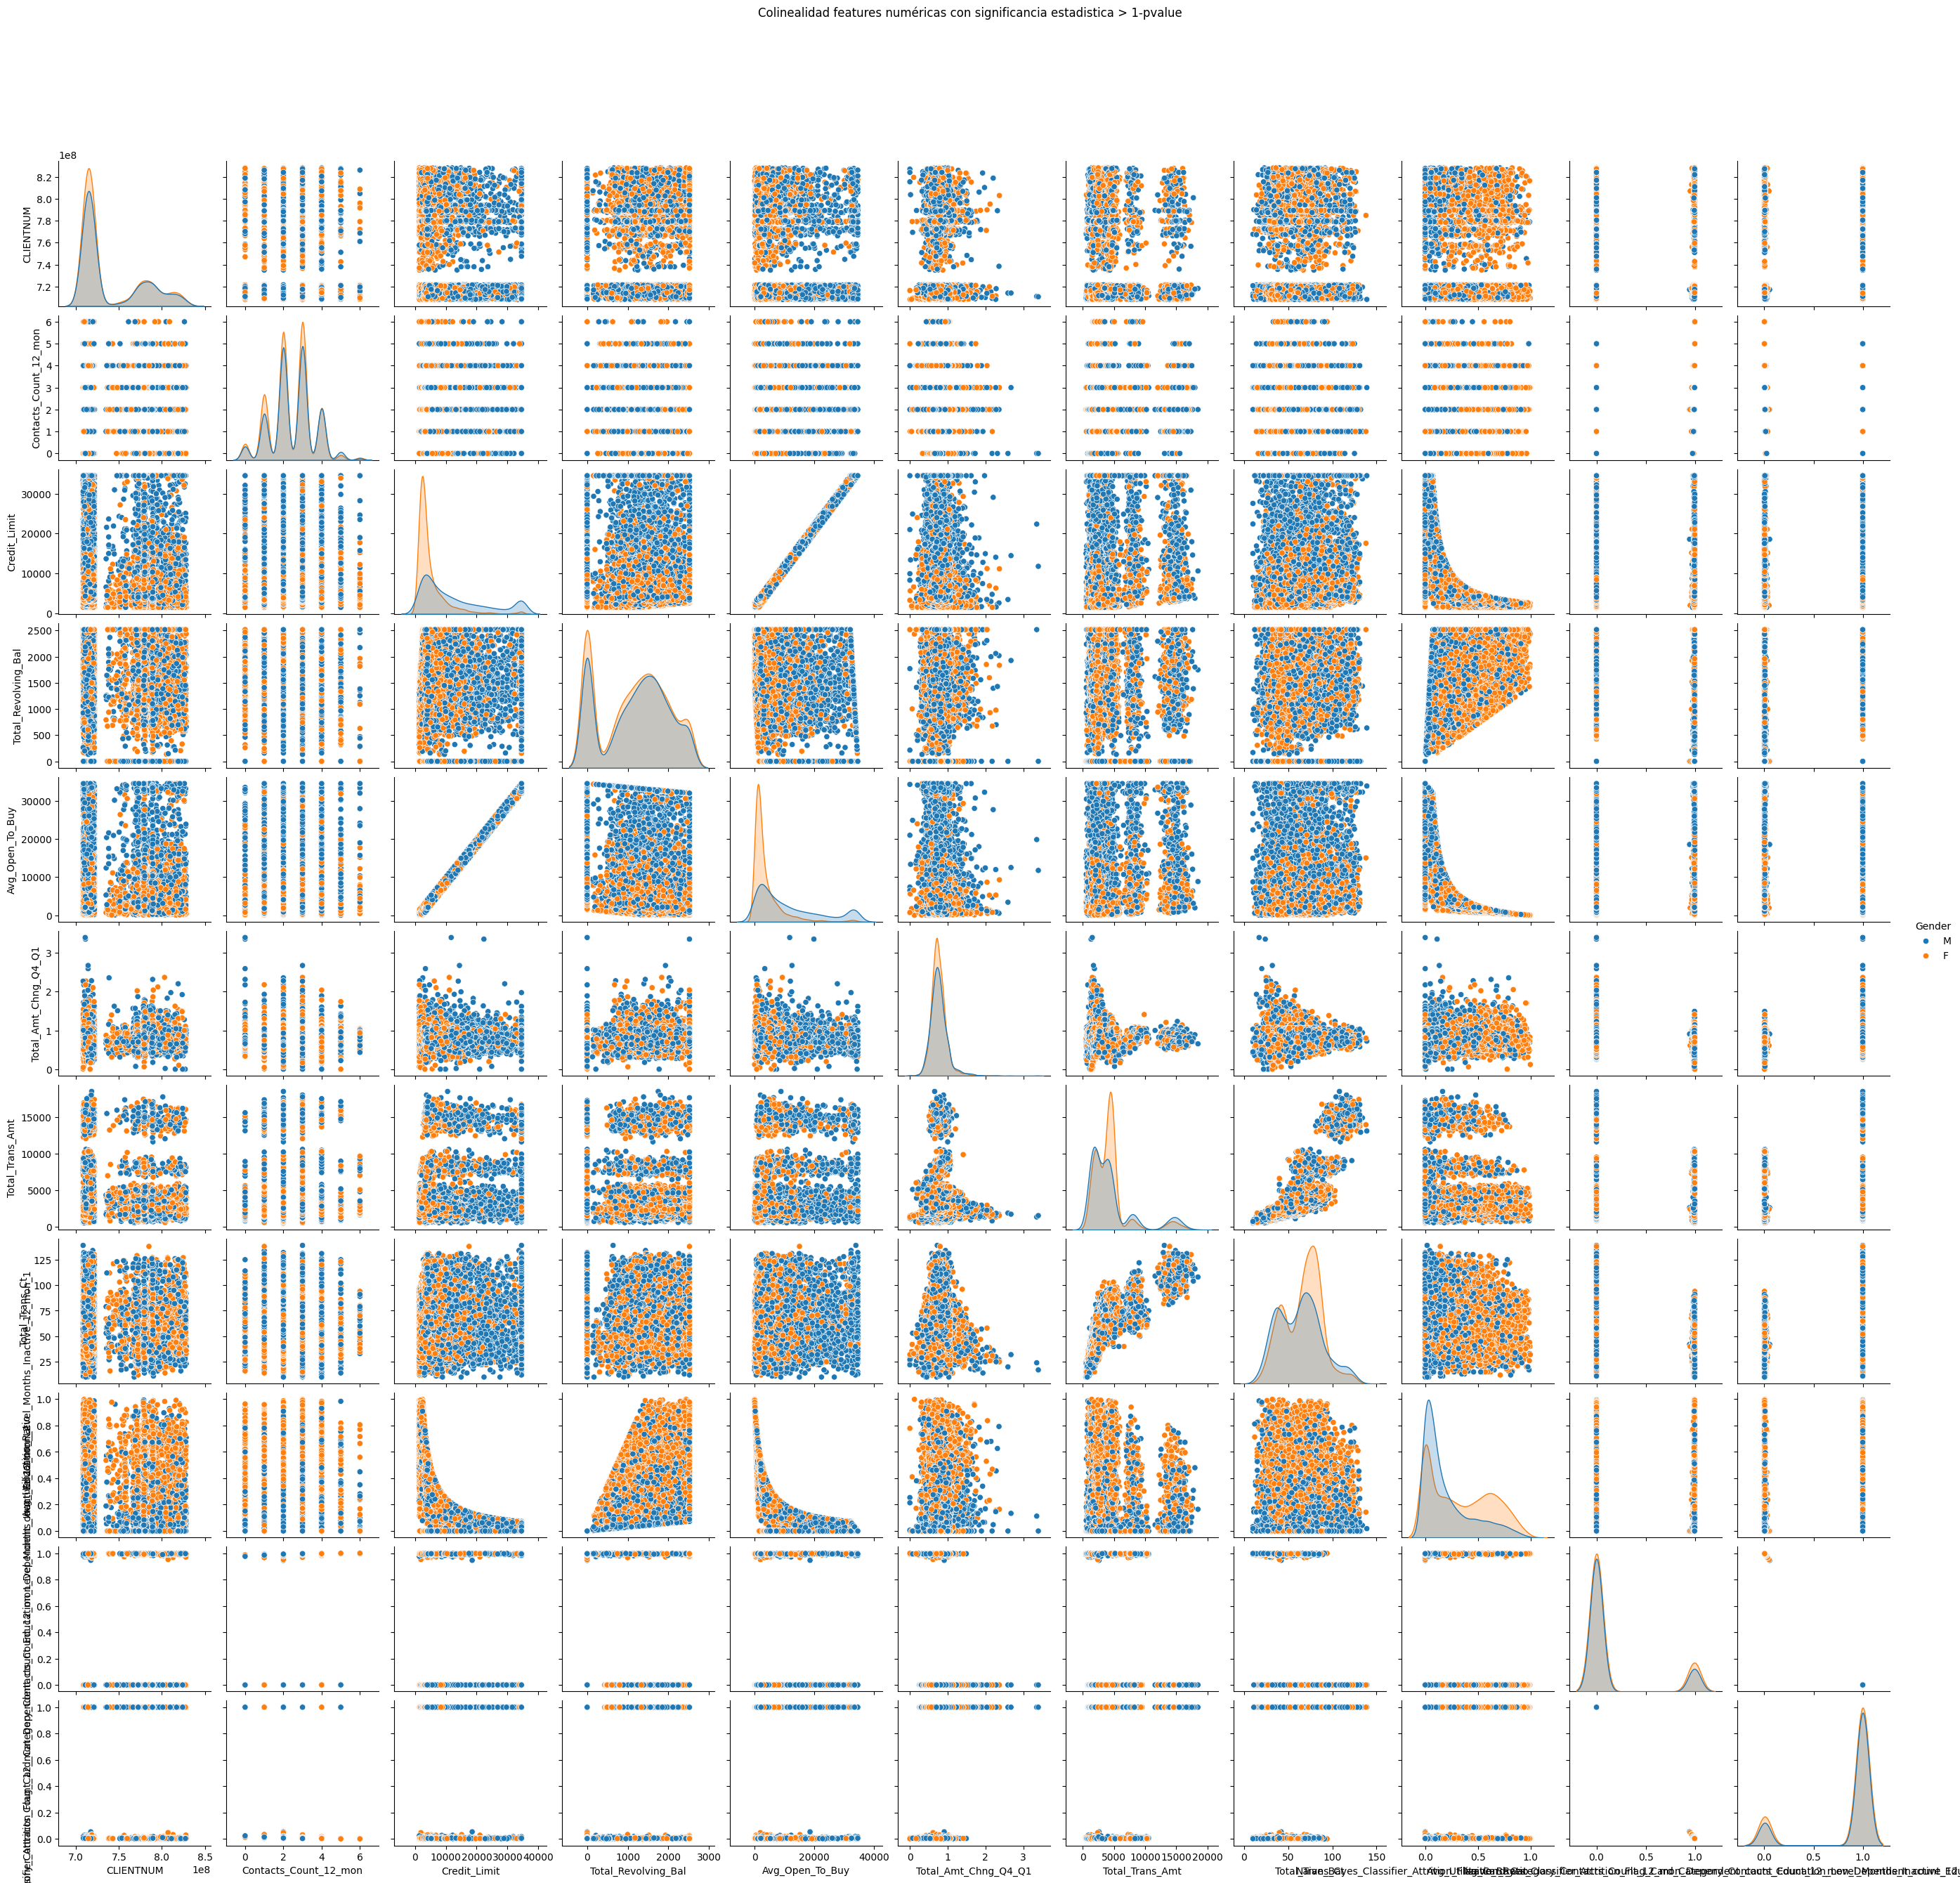

['CLIENTNUM', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']


In [20]:
x = plot_features_num_classification(df_ejemplo, 'Gender')
print(x)

In [21]:
len(x)

11

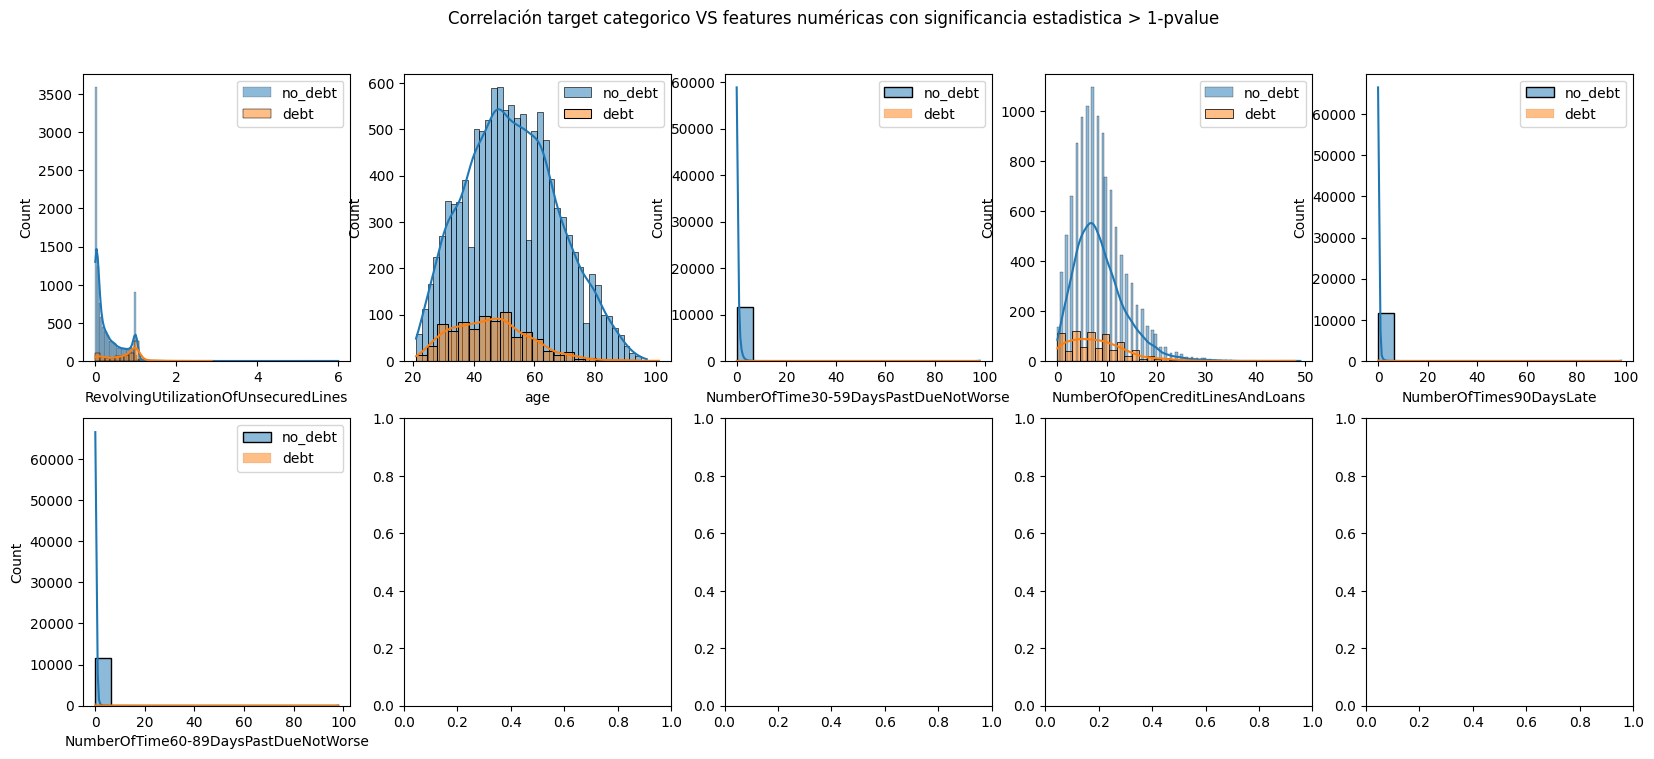

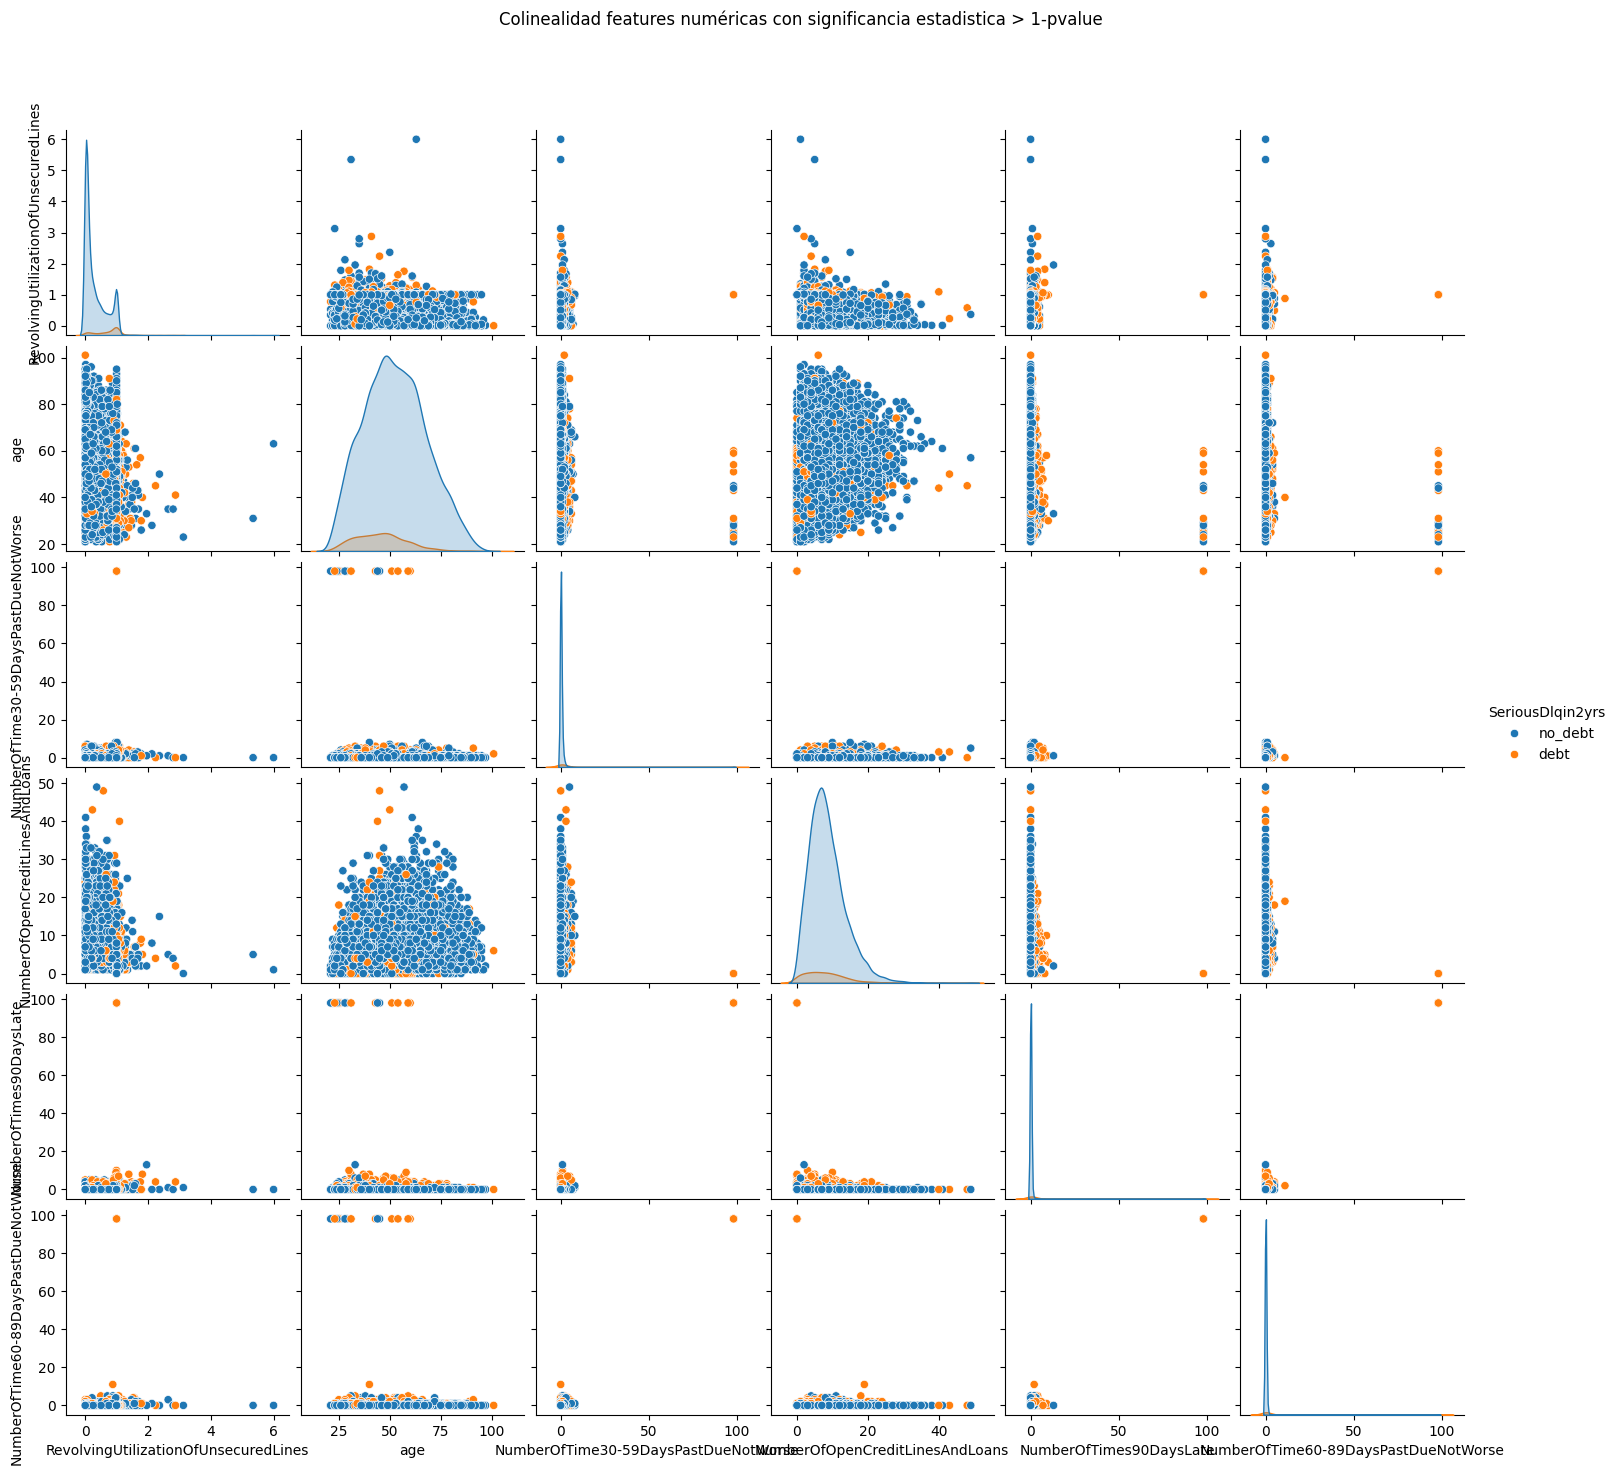

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']


In [13]:
x = plot_features_num_classification(df_banca, 'SeriousDlqin2yrs')
print(x)

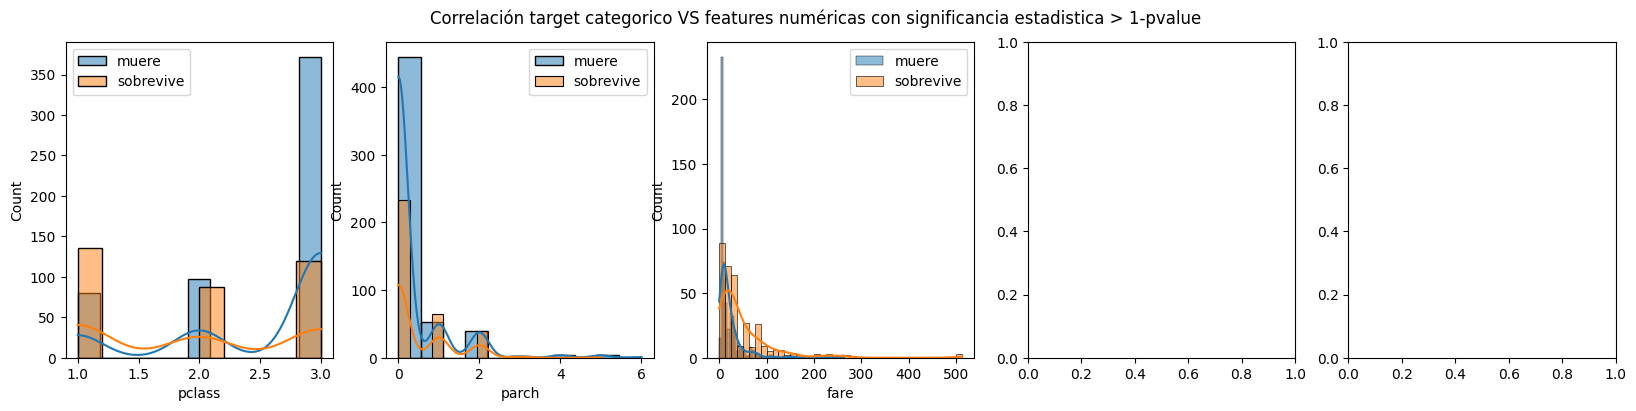

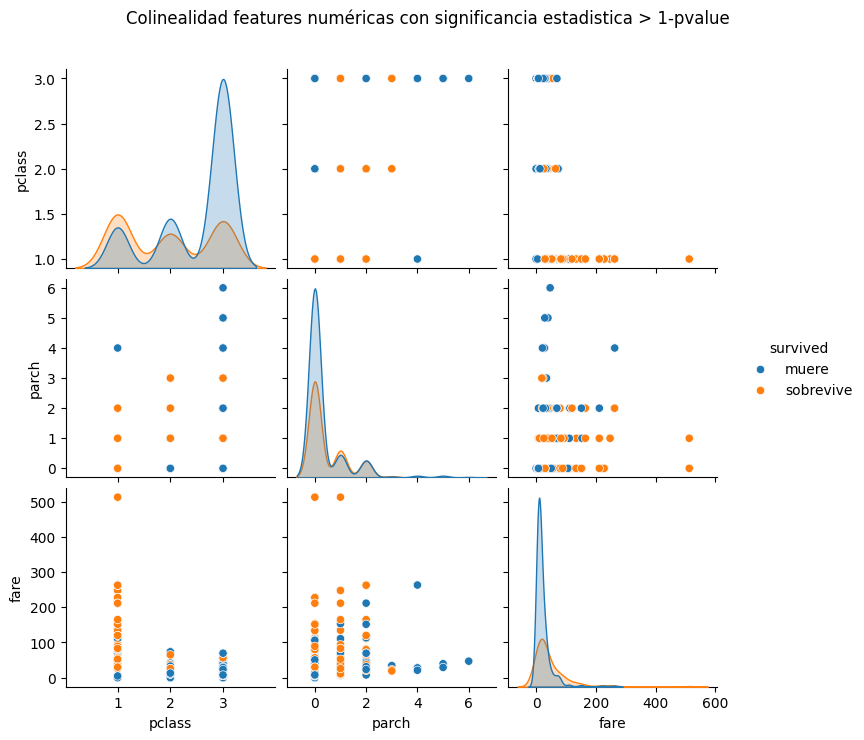

['pclass', 'parch', 'fare']


In [14]:
x = plot_features_num_classification(df_titanic, 'survived')
print(x)